# Neural Network vs. Perceptron

In [1]:
library(ggplot2)
library(hash)

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘hash’ was built under R version 3.5.2”hash-2.2.6.1 provided by Decision Patterns



### Data Preprocessing

We start by loading the data and wrangle it. The steps involved are as follows :
- Load the data
- Remove NA values
- Scale the feature

In [2]:
train = read.csv("./Task2B_train.csv")
test = read.csv("./Task2B_test.csv")

In [3]:
train = train[complete.cases(train), ]
test = test[complete.cases(test), ]


### Plotting the train data 

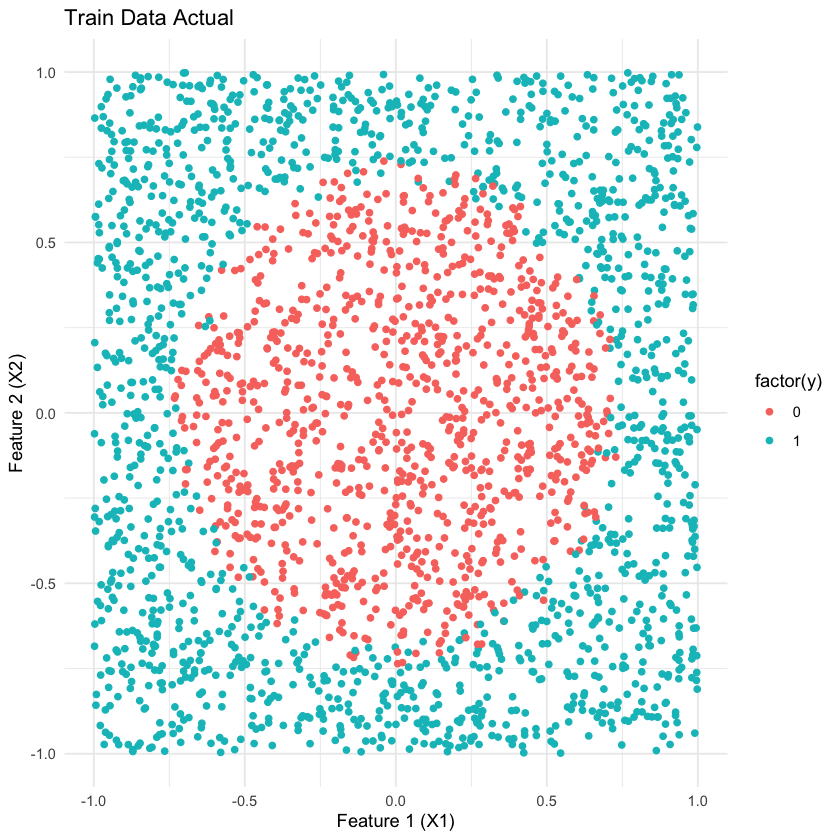

In [7]:
ggplot(data=train, aes(x=x1, y=x2, color=factor(y))) + geom_point() +
    ggtitle ('Train Data Actual') + xlab("Feature 1 (X1)") + ylab("Feature 2 (X2)")+ theme_minimal() 

In [8]:
train_features = train[,-dim(train)[2]]
train_x = scale(train_features)
train_y = train[,dim(train)[2]]

test_features = test[,-dim(test)[2]]
test_x = scale(test_features)
test_y = test[,dim(test)[2]]



For perceptron implementation,we change the label from (0,1) to (-1,1). 

In [9]:
train_c0 = which(train_y == 0)
train_y[train_c0] = -1

test_c0 = which(test_y == 0)
test_y[test_c0] = -1

### Perceptron 

The module below implements the perceptron algorithm. It takes in the training features and target to learn a decision boundary. 

In [10]:
perceptron <- function(train_x,train_y,max_tau,eta){
    set.seed(123)
    length_train = dim(train_x)[1]
    train_x = cbind(1,train_x)
    theta = matrix(runif(ncol(train_x)),ncol = 1 )
    tau = 0
    
    while (tau < max_tau){
        
    shuffeled_index <- sample(1:length_train, replace = FALSE)
    train_x <- train_x[shuffeled_index,]
        
        for( i in 1:length_train){
            hypothesis = train_x[i,] %*% theta
            if(hypothesis >=0){
                prediction = 1
            }else{
                prediction = -1
            }

            actual = train_y[i]
            if (actual != prediction){
                theta = theta + (eta * actual * matrix(train_x[i,],ncol=1))
                tau = tau +1
            }
        }
    }
    
    return(theta)  
}

The module below takes the parameters and data features to return the prediction of the model

In [11]:
predict_perceptron <- function(theta,X){
    hypothesis = cbind(1,X) %*% theta
    prediction = matrix(-1,nrow = nrow(X),ncol =1 )
    pred_positive = which(hypothesis >= 0)
    prediction[pred_positive] = 1
    return(prediction)
    
}

The module below is used to calculate `misclassification error` for a model

In [12]:
calculate_error <- function(prediction, actual){
    misclassification_count = 0
    total_observation = length(prediction)
    for( i in 1:total_observation){
        if(prediction[i] != actual[i]){  
            misclassification_count = misclassification_count + 1
        }
    }
    
    error = (misclassification_count / total_observation) * 100
    return(error)
}

The module below is used to visualise the predictions made by the percepton model.

In [13]:
visualise <- function(X,prediction,title){
    X = as.data.frame(X)
    X$prediction = prediction
    print(ggplot(data=X, aes(x=x1, y=x2, color=factor(prediction))) + geom_point() +
    ggtitle (title) + theme_minimal()+ xlab("Feature 1 (X1)") + ylab("Feature 2 (X2)"))
}

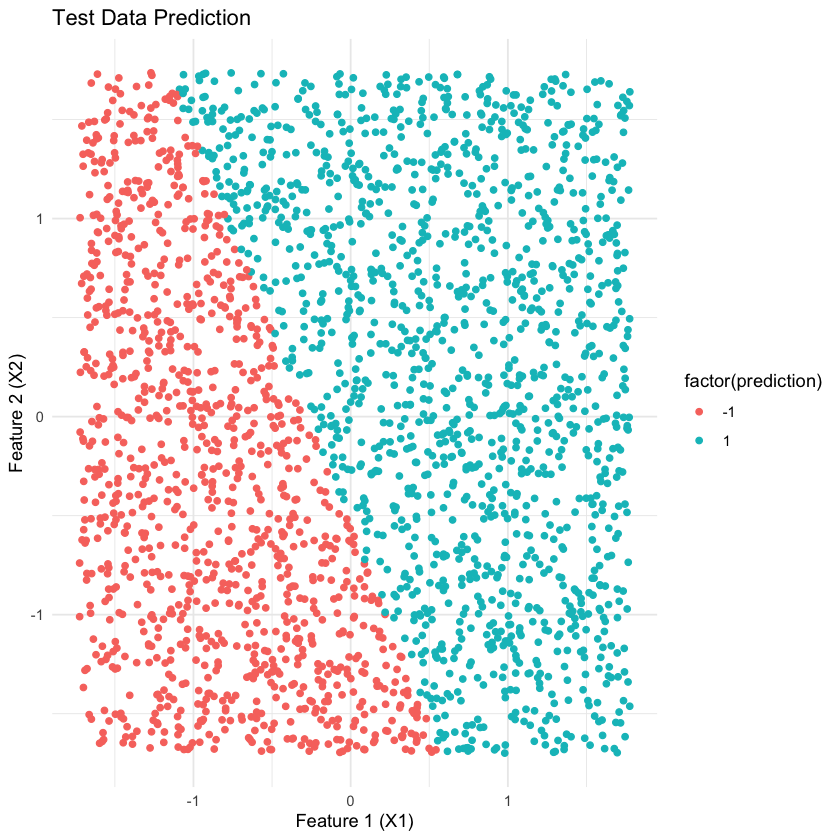

In [14]:
theta = perceptron(train_x,train_y,max_tau = 1000,eta = 0.01)
prediction = predict_perceptron(theta,test_x)
error = calculate_error(prediction,test_y)
visualise(test_x,prediction,"Test Data Prediction")

In [15]:
print(paste("Error :",error))

[1] "Error : 53.24"


From the graph above we can see that the `perceptron` model finds a linear decision boundary. This is obvious since the perceptron works well only when the data is linearly separable. In the case above, since the data is not linearly separable, the model just tries to find a decision boundary where the error is as low as possible. 

# Neural Network

For Neural Networks, we load the data again and wrangle it the same way as we did for perceptron. The steps involved are as follows :
- Load the data
- Remove NA values
- Scale the feature

In [17]:
train = read.csv("./Task2B_train.csv")
test = read.csv("./Task2B_test.csv")
train = train[complete.cases(train), ]
test = test[complete.cases(test), ]

train_features = train[,-dim(train)[2]]
train_x = scale(train_features)
train_y = train[,dim(train)[2]]

test_features = test[,-dim(test)[2]]
test_x = scale(test_features)
test_y = test[,dim(test)[2]]

N = nrow(train)

The `compute_error` function here is different from `calculate_error` above as 
- compute_error : It returns the crass entroy error for binary classification. In this case it is used to fit the neural network
- calculate_error : It returns the misclassification error for both the models i.e. perceptron and neural networks. 

In [18]:
compute_error <- function(parameters,X,Y){
    
    W1 = parameters[["W1"]] 
    W2 = parameters[["W2"]] 
    b1 = parameters[["b1"]]
    b1 = matrix(b1 , length(b1) , ncol(X) )

    b2 = parameters[["b2"]]
    b2 = matrix(b2 , length(b2) , ncol(X) )

    Z1 = (W1 %*% X) + b1
    A1 = tanh(Z1)
    
    Z2 = (W2 %*% A1) + b2
    A2 = sigmoid(Z2)
    
    error = -sum((Y * log(A2)) +((1-Y) * log(1-A2))) / nrow(X)
    return(error)
     
}


In [19]:
sigmoid <- function(Z){
    s = 1/(1+exp(-Z))
    return(s)
}

### Initialize Parameters

The module below initializes the parameters for the neurl networks. The parameters include :
- W1 : The weight matrix between the input layer and hidden layer
- W2 : The weight matrix between the hidden layer and output layer
- b1 : The bias vector between the input layer and hidden layer
- b2 : The bias vector between the hidden layer and output layer

The weight matrices are initalized to a random number close to zero to break the symmetry while the bias terms are initialized to zeros.


In [20]:
init_parameters <- function(n_x,n_h,n_y){
    parameters = hash()
    W1 = matrix(runif(n_x*n_h), nrow = n_h, ncol = n_x)
    b1 = matrix(0, nrow = n_h, ncol = 1)
    W2 = matrix(runif(n_y*n_h), nrow = n_y, ncol = n_h)
    b2 = matrix(0, nrow = n_y, ncol = 1)
    parameters[["W1"]] = W1
    parameters[["W2"]] = W2
    parameters[["b1"]] = b1
    parameters[["b2"]] = b2
    return(parameters)
}
    

### Forward Propagation

The module below performs the forward propagation for the neural networks.

In [21]:
feed_forward <- function(parameters,xi){
   
    cache = hash()
    W1 = parameters[["W1"]] 
    W2 = parameters[["W2"]] 
    b1 = parameters[["b1"]]
    b2 = parameters[["b2"]]
    
    z1 = (W1 %*% xi) + b1
    a1 = tanh(z1)

    z2 = (W2 %*% a1) + b2
    a2 = sigmoid(z2)
    
    cache[["z1"]] = z1
    cache[["z2"]] = z2
    cache[["a1"]] = a1
    cache[["a2"]] = a2

    return(cache)
}

### Backward Propagation

The module below performs the backward propagation for the neural networks by calculating the gradient for each weights and biases.

In [22]:
back_prop <- function(cache,parameters,xi,yi){
    
    grad = hash()
    W1 = parameters[["W1"]]
    b1 = parameters[["b1"]]
    W2 = parameters[["W2"]]
    b2 = parameters[["b2"]]
    
    a2 = cache[["a2"]]
    a1 = cache[["a1"]]
    z2 = cache[["z2"]]
    z1 = cache[["z1"]]
    
    dz2 = a2 - yi
    dW2 = dz2 %*% t(a1)
    db2 = dz2

    dz1 = (t(W2) %*% dz2) * (1 - (a1 ** 2))
    dW1 = dz1 %*% t(xi)
    db1 = dz1
    
    grad[["dW1"]] = dW1
    grad[["dW2"]] = dW2
    grad[["db1"]] = db1
    grad[["db2"]] = db2

    return(grad)
    
}

The module below updates the weights of the parameters based on learning rate. Since, we've tried to incorporate `SDG` for the neural network, the weight is updated after every observation.

In [23]:
update_weights <- function(parameters,grads,learning_rate,lambda){
    
    updated_parameters = hash()
    
    dW1 = grads[["dW1"]]  
    dW2 = grads[["dW2"]]  
    db1 = grads[["db1"]]  
    db2 = grads[["db2"]]  
    
    W1 = parameters[["W1"]]
    b1 = parameters[["b1"]]
    W2 = parameters[["W2"]]
    b2 = parameters[["b2"]]
    
    W1 = W1 - (learning_rate * (dW1 + (lambda * W1)))
    W2 = W2 - (learning_rate * (dW2 + (lambda * W2)))
    b1 = b1 - (learning_rate * db1)
    b2 = b2 - (learning_rate * db2)
    
    updated_parameters[["W1"]] = W1
    updated_parameters[["W2"]] = W2
    updated_parameters[["b1"]] = b1
    updated_parameters[["b2"]] = b2
    
    return(updated_parameters)
    
}

The module below performs the following task :
- inititialise the parameters
- for each observation
    - perform forward propagation and calculate the cross entropy error
    - perform backward propogation and calculate gradient
    - updates the weights

In [24]:
neural_net <- function(train_x,train_y,lambda= 0,max_tau,n_x,n_h,n_y,learning_rate){
    X = t(train_x)    
    Y = matrix(train_y,nrow = 1)
    errors = c()
    parameters = init_parameters(n_x,n_h,n_y)
    tau = 0
    while(tau < max_tau){
        for (i in 1:ncol(X)){
            xi = X[,i]
            yi = train_y[i]
            error = compute_error(parameters,X,Y)
            errors = c(errors,error)
            cache = feed_forward(parameters,xi)
            grad = back_prop(cache,parameters,xi,yi)
            parameters = update_weights(parameters,grad,learning_rate,lambda)
            tau = tau + 1
            if(tau == max_tau){
                break
            }
        }
    }
    return(parameters)
    
}

The module below predicts the class for each observation based on the parameters learnt by the model.

In [25]:
predict_nn <- function(parameters,X){
    
    X = t(X)
    
    W1 = parameters[["W1"]] 
    W2 = parameters[["W2"]] 
    b1 = parameters[["b1"]]
    b1 = matrix(b1 , length(b1) , ncol(X) )
    b2 = parameters[["b2"]]
    b2 = matrix(b2 , length(b2) , ncol(X) )

    Z1 = (W1 %*% X) + b1
    A1 = tanh(Z1)

    Z2 = (W2 %*% A1) + b2
    A2 = sigmoid(Z2)
    
    prediction = matrix(round(A2),ncol =1)
    return(prediction)
    
}


In [26]:
test_error = data.frame("num_hidden"= seq(2,100,2),"error"=0)
for(num_hidden in seq(2,100,2)){
    parameters = neural_net(train_x,train_y,lambda= 0.0001,max_tau = N*5 ,n_x =2,n_h=num_hidden,n_y =1,learning_rate = 0.01)
    prediction = predict_nn(parameters,test_x)
    test_error[num_hidden/2,"error"] = calculate_error(prediction, test_y)
}



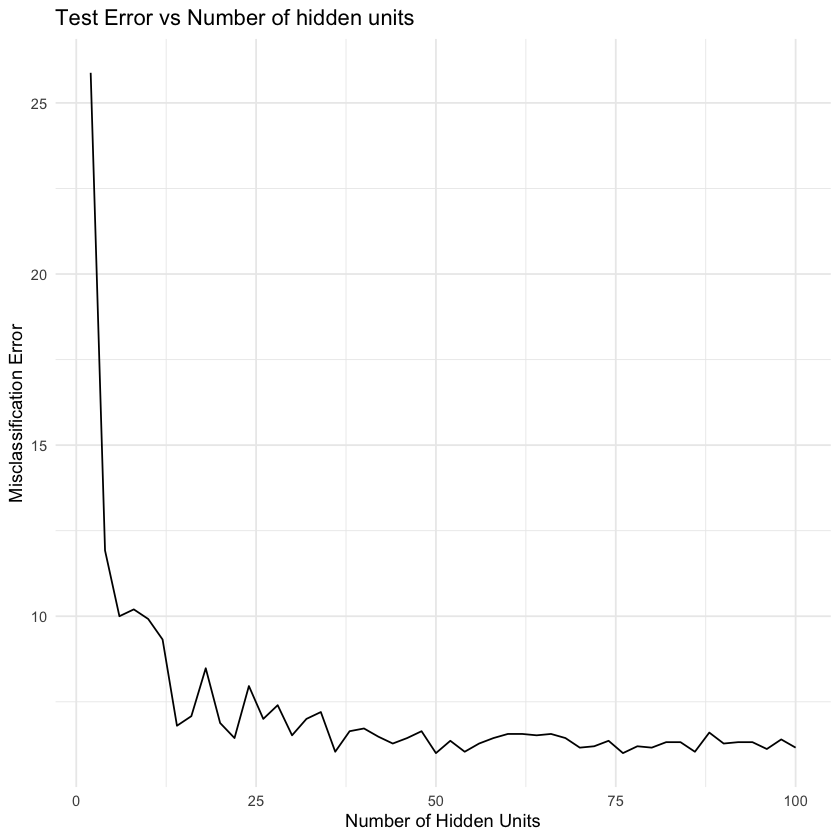

In [27]:
print(ggplot(data=test_error, aes(x=num_hidden, y=error)) + geom_line() + 
      ggtitle ("Test Error vs Number of hidden units")+ xlab("Number of Hidden Units") + 
      ylab("Misclassification Error") + theme_minimal())



In [28]:
test_error[test_error$error == min(test_error$error),][1,]

,num_hidden,error
25,50,6


In [29]:
parameters = neural_net(train_x,train_y,lambda= 0.0001,max_tau = N*5 ,n_x =2,n_h=50,n_y =1,learning_rate = 0.01)
prediction_final = predict_nn(parameters,test_x)


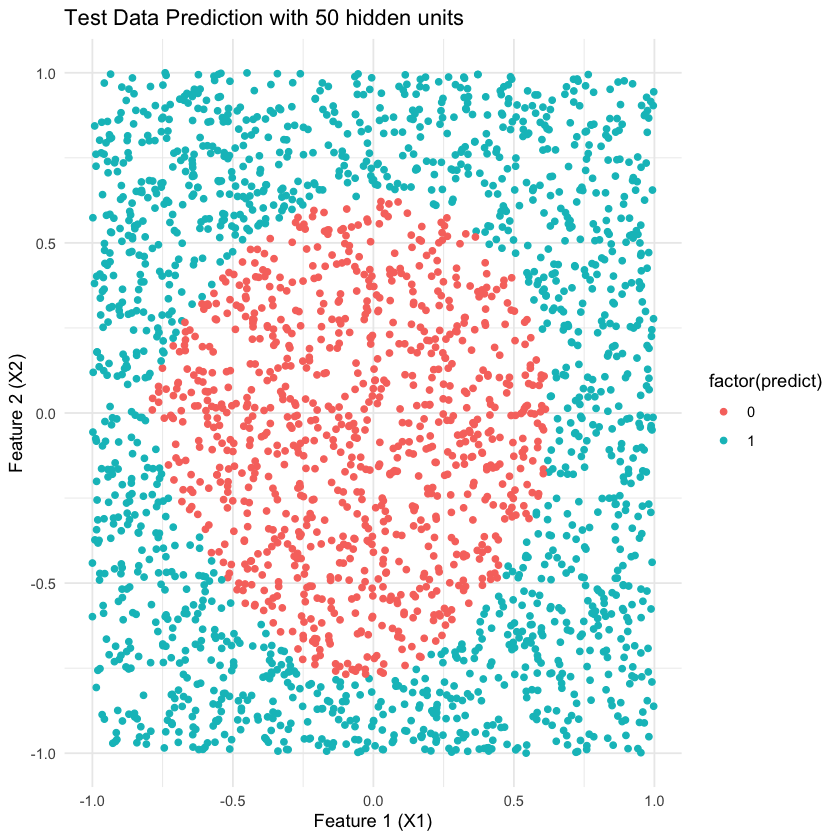

In [30]:
test$predict = prediction_final
ggplot(data=test, aes(x=x1, y=x2, color=factor(predict))) + geom_point() +
    ggtitle ('Test Data Prediction with 50 hidden units') + theme_minimal() + xlab("Feature 1 (X1)") + ylab("Feature 2 (X2)")

In [44]:
write.csv(test_error, file = "test_error.csv")
